In [1]:
%matplotlib inline
import time
import pandas as pd
import matplotlib as mt
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
from keras.utils import to_categorical
import sklearn
from sklearn.preprocessing import MinMaxScaler
import keras 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import LSTM
from keras.layers.recurrent import SimpleRNN
from keras import activations
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from numpy import concatenate
from math import sqrt

Using TensorFlow backend.


Ici nous allons rajouter d'autres variables pertinentes pour l'apprentissage du premier modèle de prédiction ainsi que le modèle d'apprentissage de l'erreur.

Ces variables sont: 
* Volume
* priceChange

elles doivent être toutefois centrées et réduites sur p période (p à fixer).

In [2]:
def initial_dataframe(variables):
    
    df = pd.read_csv('FDAX_indicateurs.txt', sep='\t', skipinitialspace=True)
    #skipinitialspace permet de retirer les espaces génants sur les colonnes et sur les données

    #suppression des colonnes non utiles à la prédiction
    colonnes = ['Volume', '# of Trades','OHLC Avg', 'HLC Avg', 'HL Avg', 'Bid Volume', 'Ask Volume', 'Open.1','High.1', 'Low.1', 'Close', "etat variable 'Volume'","etat variable 'DeltaSpread'", "etat variable 'PriceChange'","etat variable 'Delta'", 'volume', 'deltaSpread', 'priceChange','delta', "etat variable 'spread'", "etat variable 'open'","etat variable 'close'", "etat variable 'deltaOpen'","etat variable 'deltaClose'", 'weak', 'strong', 'Strong Triangle','weak Triangle', 'delta_sos', 'delta_sow', "Signal d'achat",'Signal de vente', 'trendFilter']
    for variable in variables:
        if (variable!='priceChange') and (variable!= 'Spread'):
            colonnes.remove(variable)    
    df.drop(colonnes, axis = 1, inplace = True)

    #transforamtion du dataframe pour avoir la date et l'heure en objet datetime et en indice du dataframe
    df['Date&Time'] = df['Date'] +' '+ df['Time']
    df['date_time'] = pd.to_datetime(df['Date&Time'], format='%d/%m/%Y %H:%M:%S.%f')
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S.%f')
    df.drop(['Date', 'Date&Time'], axis=1, inplace=True)
    List=['date_time']
    for column in df.columns:
        if column != 'date_time':
            List.append(column)
    df = df[List]
    
    if 'priceChange' in variables:
        PC = []
        for i in range(1,df.shape[0]):
            PC.append(df['Last'].iloc[i] - df['Last'].iloc[i-1])
        df = df.iloc[1:, :]
        df.insert(df.shape[1], 'priceChange', PC)
        
    if 'Spread' in variables:
        df['Spread'] = df['High'] - df['Low']
        
    
    #rajout de la colonne des labels:
    Y=[]
    n = df.shape[0]
    for i in range (1,n) : 
        if df.iloc[i,5]<df.iloc[i-1,5]:
            Y.append(-1)
        if df.iloc[i,5]==df.iloc[i-1,5]:
            Y.append(0)
        if df.iloc[i,5]>df.iloc[i-1,5]:
            Y.append(1)
    
    df = df.iloc[1:,:]
    df.insert(df.shape[1], 'Y', Y)
    return df

In [3]:
def zscoring(var, p):
    s = var.copy(deep=True)
    mean = s.copy(deep=True).rolling(p).mean()
    sigma = s.copy(deep=True).rolling(p).std(ddof=0)
    s = (s-mean)/sigma
    
    return s

In [4]:
variables=['Volume', 'priceChange']
df_initial = initial_dataframe(variables) 
df_initial

,date_time,Time,Open,High,Low,Last,Volume,priceChange,Y
2,2013-01-04 08:10:00,1900-01-01 08:10:00,7837.5,7837.5,7833.0,7836.5,477,-1.5,-1
3,2013-01-04 08:15:00,1900-01-01 08:15:00,7836.5,7840.0,7835.5,7839.5,191,3.0,1
4,2013-01-04 08:20:00,1900-01-01 08:20:00,7840.0,7840.0,7837.0,7837.0,81,-2.5,-1
5,2013-01-04 08:25:00,1900-01-01 08:25:00,7837.0,7842.5,7836.5,7840.5,164,3.5,1
6,2013-01-04 08:30:00,1900-01-01 08:30:00,7840.5,7841.5,7839.0,7840.0,112,-0.5,-1
...,...,...,...,...,...,...,...,...,...
296602,2019-12-11 21:40:00,1900-01-01 21:40:00,13144.5,13150.0,13144.0,13149.5,206,5.5,1
296603,2019-12-11 21:45:00,1900-01-01 21:45:00,13150.0,13153.0,13143.0,13144.5,381,-5.0,-1
296604,2019-12-11 21:50:00,1900-01-01 21:50:00,13145.0,13155.0,13145.0,13154.5,428,10.0,1
296605,2019-12-11 21:55:00,1900-01-01 21:55:00,13153.0,13154.0,13147.5,13151.0,204,-3.5,-1


Garder juste les données pour l'année 2013 (entre 8h et 18h):

In [5]:
date_limite = dt.datetime.strptime('2014-01-01 08:00:00.0', '%Y-%m-%d %H:%M:%S.%f')
dix_huit = dt.datetime.strptime('18:05:00.0', '%H:%M:%S.%f')
df_initial_2013 = df_initial.copy(deep=True)
df_initial_2013 = df_initial_2013.loc[(df_initial_2013["date_time"]<date_limite) & (df_initial_2013["Time"]<dix_huit)]
index_2013 = np.linspace(1, df_initial_2013.shape[0], num=df_initial_2013.shape[0], dtype='int64')
df_initial_2013.index = index_2013 
df_initial_2013

,date_time,Time,Open,High,Low,Last,Volume,priceChange,Y
1,2013-01-04 08:10:00,1900-01-01 08:10:00,7837.5,7837.5,7833.0,7836.5,477,-1.5,-1
2,2013-01-04 08:15:00,1900-01-01 08:15:00,7836.5,7840.0,7835.5,7839.5,191,3.0,1
3,2013-01-04 08:20:00,1900-01-01 08:20:00,7840.0,7840.0,7837.0,7837.0,81,-2.5,-1
4,2013-01-04 08:25:00,1900-01-01 08:25:00,7837.0,7842.5,7836.5,7840.5,164,3.5,1
5,2013-01-04 08:30:00,1900-01-01 08:30:00,7840.5,7841.5,7839.0,7840.0,112,-0.5,-1
...,...,...,...,...,...,...,...,...,...
30259,2013-12-30 17:40:00,1900-01-01 17:40:00,9651.5,9654.0,9650.5,9652.5,137,0.5,1
30260,2013-12-30 17:45:00,1900-01-01 17:45:00,9652.0,9659.0,9652.0,9655.5,112,3.0,1
30261,2013-12-30 17:50:00,1900-01-01 17:50:00,9655.5,9658.5,9654.5,9658.0,73,2.5,1
30262,2013-12-30 17:55:00,1900-01-01 17:55:00,9658.0,9658.5,9655.0,9658.0,67,0.0,0


In [6]:
def preprocessing(df, varibles):
    #On exclut la date et l'heure qui ne sont pas des données d'apprentissage et les labels
    n = df_initial_2013.shape[0]
    limit = int(4*n/5)
    values_app = df.copy(deep=True).iloc[:limit,2:6].values

    #Processus de normalisation à partir des données d'apprentissage
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler = scaler.fit(values_app)

    #Normalisation de l'ensemble des données à partir du modèle de normalisation construit sur les données d'apprentissage
    values = df_initial_2013.copy(deep=True).iloc[:,2:6].values
    normalized = scaler.transform(values)
    processed_data = pd.DataFrame(normalized)
    colonnes = ['Open', 'High', 'Low', 'Last']
    processed_data.columns = colonnes

    #zscoring des deux variables Volume et priceChange:
    for variable in variables:
        var = df[[variable]].copy(deep=True)
        var_zscore = zscoring(var, 23)
        columnTitle = variable + '_zscoring'
        processed_data.insert(processed_data.shape[1], columnTitle, var_zscore)    

    #éliminer les lignes avec des valeurs Nan provenant du calcul des zscore sur une période de 23 unités
    processed_data = processed_data.iloc[23:, :] #Ce dataframe représente le tableau des données normalisées/zscorées (joue le rôle de normalized dans la première étape).

    #placer le Last à la dernière colonne de processed_data_var:
    L = []
    for column in processed_data.columns:
        if column != 'Last':
            L.append(column)
    L.append('Last')
    processed_data = processed_data[L]

    #rajouter une colonne pour les labels:
    processed_data_label = processed_data.copy(deep=True) 
    processed_data_label.index = processed_data_label.index+1
    processed_data_label['Y'] = df_initial_2013.copy(deep=True)['Y'].iloc[23:]
    processed_data_label #ce dataframe représente le tableau des données normalisées/zscorées avec leurs labels (joue le rôle de processed_data dans la première étape).
    
    return limit, scaler, processed_data, processed_data_label



In [7]:
limit, scaler, processed_data, processed_data_label = preprocessing(df_initial_2013, variables)

In [8]:
processed_data_label

,Open,High,Low,Volume_zscoring,priceChange_zscoring,Last,Y
24,0.234369,0.233688,0.243186,-0.109841,-0.729137,0.236429,1
25,0.235798,0.234043,0.241416,-0.188668,0.594342,0.236071,-1
26,0.235441,0.233333,0.243186,0.294820,-0.342765,0.235357,-1
27,0.234727,0.232624,0.241416,-0.608886,-0.584708,0.233929,-1
28,0.233655,0.232624,0.242478,-0.293489,-0.916853,0.233571,-1
...,...,...,...,...,...,...,...
30259,1.524830,1.514539,1.521416,0.024667,0.739365,1.525357,1
30260,1.525188,1.518085,1.522478,-0.584860,0.044688,1.527500,1
30261,1.527688,1.517730,1.524248,-0.712437,0.602809,1.529286,1
30262,1.529475,1.517730,1.524602,-0.897280,0.432834,1.529286,0


Maintenant que les données sont normalisées et labelisées, répartissons les sur un échantillon de train et un autre de test selon un time_lag à fixer à l'avance. 

In [9]:
def build_dataset(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [10]:
def data(time_lag, variables, processed_data, limit): #time_lag = parameter to design how many time steps to consider in the input data 
    
    ndrop = time_lag*(4+len(variables))
    scaled = processed_data.values
    processed_data_lstm = build_dataset(scaled, time_lag, 1)
    L = [ndrop, ndrop + 1, ndrop + 2]
    for i in range(1, len(variables) + 1):
        L.append(ndrop+2+i)
    processed_data_lstm.drop(processed_data_lstm.columns[L], axis=1, inplace=True)
    
    # split into train and test sets
    values = processed_data_lstm.values #values is a numpy representation of processed_data, which is data normalized for prediction
    train = values[:limit, :]
    test = values[limit:, :]
    
    # split into input and outputs
    X_train_lstm, Y_train_lstm = train[:, :-1], train[:, -1] #train_X takes all columns minus the last one which stands for the value of the Last
    X_test_lstm, Y_test_lstm = test[:, :-1], test[:, -1]
    
    # reshape input to be 3D [samples, timesteps, features]
    X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], 1, X_train_lstm.shape[1]))
    X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], 1, X_test_lstm.shape[1]))
    
    print("shape of X_train_lstm: ", X_train_lstm.shape)
    print("shape of Y_train_lstm: ", Y_train_lstm.shape)
    print("shape of X_test_lstm: ", X_test_lstm.shape)
    print("shape of Y_test_lstm: ", Y_test_lstm.shape)
    
    return(X_train_lstm, Y_train_lstm, X_test_lstm, Y_test_lstm)


In [11]:
def model(X_train_lstm_last):
    model = Sequential()
    model.add(LSTM(256, input_shape=(X_train_lstm_last.shape[1], X_train_lstm_last.shape[2]), return_sequences=True))
    model.add(LSTM(256, return_sequences=True))
    model.add(LSTM(256, return_sequences=False))
    model.add(Dense(1, activation='linear'))
    model.compile(loss = 'mse', 
                 optimizer=keras.optimizers.Adagrad(), 
                 metrics=['mean_squared_error'])
    return(model)

In [12]:
X_train_lstm, Y_train_lstm, X_test_lstm, Y_test_lstm = data(2, variables, processed_data, limit)

shape of X_train_lstm:  (24210, 1, 12)
shape of Y_train_lstm:  (24210,)
shape of X_test_lstm:  (6028, 1, 12)
shape of Y_test_lstm:  (6028,)


In [13]:
batch_size = 64
epochs = 200

model = model(X_train_lstm)
history = model.fit(X_train_lstm, Y_train_lstm,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose = 1,
                    validation_data=(X_test_lstm, Y_test_lstm))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Train on 24210 samples, validate on 6028 samples
Epoch 1/200
24210/24210 [==============================] - 7s 294us/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 2/200
24210/24210 [==============================] - 6s 252us/step - loss: 4.9164e-05 - mean_squared_error: 4.9164e-05 - val_loss: 1.4206e-04 - val_mean_squared_error: 1.4206e-04
Epoch 3/200
24210/24210 [==============================] - 6s 259us/step - loss: 4.0152e-05 - mean_squared_error: 4.0152e-05 - val_loss: 7.3937e-04 - val_mean_squared_error: 7.3937e-04
Epoch 4/200
24210/24210 [==============================] - 6s 256us/step - loss: 3.9369e-05 - mean_squared_error: 3.9369e-05 - val_loss: 9.4611e-04 - val_mean_squared_error: 9.4611e-04
Epoch 5/200
24210/24210 [==============================] - 6s 235us/step - loss: 3.9268e-05 - mean_squared_error: 3.9268e-05 - val_loss: 7.2848e-

Epoch 42/200
24210/24210 [==============================] - 6s 260us/step - loss: 3.3898e-05 - mean_squared_error: 3.3898e-05 - val_loss: 3.6676e-04 - val_mean_squared_error: 3.6676e-04
Epoch 43/200
24210/24210 [==============================] - 6s 257us/step - loss: 3.3960e-05 - mean_squared_error: 3.3960e-05 - val_loss: 5.2823e-04 - val_mean_squared_error: 5.2823e-04
Epoch 44/200
24210/24210 [==============================] - 7s 279us/step - loss: 3.3887e-05 - mean_squared_error: 3.3887e-05 - val_loss: 3.4008e-04 - val_mean_squared_error: 3.4008e-04
Epoch 45/200
24210/24210 [==============================] - 6s 255us/step - loss: 3.3630e-05 - mean_squared_error: 3.3630e-05 - val_loss: 9.0674e-04 - val_mean_squared_error: 9.0674e-04
Epoch 46/200
24210/24210 [==============================] - 6s 252us/step - loss: 3.3877e-05 - mean_squared_error: 3.3877e-05 - val_loss: 4.9851e-04 - val_mean_squared_error: 4.9851e-04
Epoch 47/200
24210/24210 [==============================] - 6s 259us/s

24210/24210 [==============================] - 6s 257us/step - loss: 3.1677e-05 - mean_squared_error: 3.1677e-05 - val_loss: 2.5653e-04 - val_mean_squared_error: 2.5653e-04
Epoch 87/200
24210/24210 [==============================] - 6s 245us/step - loss: 3.1440e-05 - mean_squared_error: 3.1440e-05 - val_loss: 1.8742e-04 - val_mean_squared_error: 1.8742e-04
Epoch 88/200
24210/24210 [==============================] - 6s 244us/step - loss: 3.1544e-05 - mean_squared_error: 3.1544e-05 - val_loss: 2.6705e-04 - val_mean_squared_error: 2.6705e-04
Epoch 89/200
24210/24210 [==============================] - 6s 251us/step - loss: 3.1425e-05 - mean_squared_error: 3.1425e-05 - val_loss: 2.8177e-04 - val_mean_squared_error: 2.8177e-04
Epoch 90/200
24210/24210 [==============================] - 6s 241us/step - loss: 3.1401e-05 - mean_squared_error: 3.1401e-05 - val_loss: 2.8014e-04 - val_mean_squared_error: 2.8014e-04
Epoch 91/200
24210/24210 [==============================] - 6s 258us/step - loss: 3

Epoch 130/200
24210/24210 [==============================] - 7s 280us/step - loss: 2.9954e-05 - mean_squared_error: 2.9954e-05 - val_loss: 1.7282e-04 - val_mean_squared_error: 1.7282e-04
Epoch 131/200
24210/24210 [==============================] - 6s 245us/step - loss: 2.9653e-05 - mean_squared_error: 2.9653e-05 - val_loss: 1.5531e-04 - val_mean_squared_error: 1.5531e-04
Epoch 132/200
24210/24210 [==============================] - 6s 244us/step - loss: 3.0147e-05 - mean_squared_error: 3.0147e-05 - val_loss: 1.4884e-04 - val_mean_squared_error: 1.4884e-04
Epoch 133/200
24210/24210 [==============================] - 6s 244us/step - loss: 2.9624e-05 - mean_squared_error: 2.9624e-05 - val_loss: 1.9581e-04 - val_mean_squared_error: 1.9581e-04
Epoch 134/200
24210/24210 [==============================] - 6s 248us/step - loss: 2.9940e-05 - mean_squared_error: 2.9940e-05 - val_loss: 1.5050e-04 - val_mean_squared_error: 1.5050e-04
Epoch 135/200
24210/24210 [==============================] - 6s 2

Epoch 174/200
24210/24210 [==============================] - 6s 236us/step - loss: 2.8497e-05 - mean_squared_error: 2.8497e-05 - val_loss: 1.5162e-04 - val_mean_squared_error: 1.5162e-04
Epoch 175/200
24210/24210 [==============================] - 6s 252us/step - loss: 2.8608e-05 - mean_squared_error: 2.8608e-05 - val_loss: 1.1068e-04 - val_mean_squared_error: 1.1068e-04
Epoch 176/200
24210/24210 [==============================] - 6s 238us/step - loss: 2.8637e-05 - mean_squared_error: 2.8637e-05 - val_loss: 2.6115e-04 - val_mean_squared_error: 2.6115e-04
Epoch 177/200
24210/24210 [==============================] - 6s 251us/step - loss: 2.8464e-05 - mean_squared_error: 2.8464e-05 - val_loss: 1.2980e-04 - val_mean_squared_error: 1.2980e-04
Epoch 178/200
24210/24210 [==============================] - 6s 245us/step - loss: 2.8528e-05 - mean_squared_error: 2.8528e-05 - val_loss: 8.2306e-05 - val_mean_squared_error: 8.2306e-05
Epoch 179/200
24210/24210 [==============================] - 7s 2

In [14]:
Y_test_lstm.shape

(6028,)

In [15]:
processed_data.iloc[limit+2:, 3].shape

(6028,)

In [16]:
def prediction (test_X, test_y, model, scaler):
    # faire la prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

    # inverser le scaling pour les données prédites
    inv_yhat = concatenate((test_X[:,:3],yhat), axis=1) #concatenation column-wise
    inv_yhat = scaler.inverse_transform(inv_yhat) #the values were scaled before putting them into the neural networks, this operation makes the inverse operation so that the values are comprehensible
    inv_yhat = inv_yhat[:,3]

    # inverser le scaling pour les vraies valeurs 
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_X[:,:3],test_y), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,3]
   
    #liste des valeurs du Low
    #val_low_test = df_initial_2013.values[limit+2:,3]
    
    #liste des valeurs du High
    #val_high_test = df_initial_2013.values[limit+2:,2]
    
    return(inv_yhat, yhat, inv_y)

In [17]:
last_prediction, last_prediction_norm, last_real = prediction(X_test_lstm, Y_test_lstm, model, scaler)

In [18]:
y_prediction_shift = last_prediction[1::]
y_real_shift = last_real[:-1]

In [19]:
y_prediction_shift.shape

(6027,)

In [20]:
y_prediction_shift

array([8864.74730206, 8860.8964963 , 8849.15565681, ..., 9632.03889561,
       9632.53273201, 9632.86267948])

In [21]:
last_prediction

array([8861.91829872, 8864.74730206, 8860.8964963 , ..., 9632.03889561,
       9632.53273201, 9632.86267948])

In [22]:
y_real_shift.shape

(6027,)

In [23]:
def tracer_prediction(nb_points, inv_yhat, inv_y):  #nb_points est le nombre de points considérés
    plt.figure(figsize=(15, 9))
    plt.plot(inv_yhat[:nb_points], lw=1, label="Prediction")
    plt.plot(inv_y[0:nb_points], lw=1, label='Valeur réelle')
    plt.legend(fontsize=14)
    plt.title('Comparaison entre les valeurs réelles et prédites par notre modèle', fontsize=16)
    plt.xlabel('Nombre de mesures du Last', fontsize=14)
    plt.ylabel('Evolution de la valeur du Last sur les données de test', fontsize=14)
    plt.tight_layout()

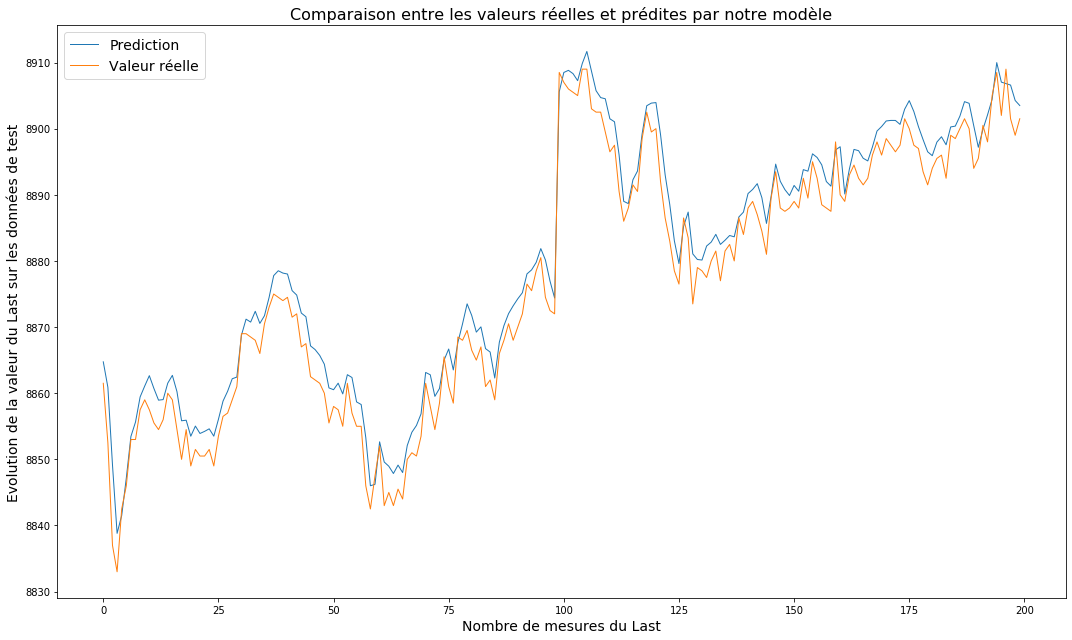

In [24]:
nb_points = 200
tracer_prediction(nb_points,y_prediction_shift, y_real_shift)

In [25]:
rmse = sqrt(mean_squared_error(last_prediction, last_real))
rmse

9.188698665320498

In [26]:
processed_data_label.iloc[limit+4:, :].shape

(6026, 7)

In [27]:
def erreur_classification(last_prediction_corr, df_corr):
    Y_hat=[]
    n_test = last_prediction_corr.shape[0]
    for i in range (1,n_test): 
        if last_prediction_corr[i] < last_prediction_corr[i-1]:
            Y_hat.append(-1)
        if last_prediction_corr[i] == last_prediction_corr[i-1]:
            Y_hat.append(0)
        if last_prediction_corr[i] > last_prediction_corr[i-1]:
            Y_hat.append(1)
    
    df_classification = df_corr.iloc[limit+4:, :].copy(deep=True)
    df_classification.insert(df_classification.shape[1],'Y_hat',Y_hat)

    s = 0
    l = len(variables)
    n = df_classification.shape[0]
    for i in range (0,n):
        if df_classification.iloc[i, 4+l] != Y_hat[i]:
            s+=1
    erreur = (s/n)*100
    
    
    return erreur

In [28]:
erreur = erreur_classification(y_prediction_shift, processed_data_label)

In [29]:
erreur

56.2562230335214

Apprenons maintenant l'erreur:

In [30]:
def error_dataframe(processed_data_label, limit, yhat, variables):
    #reprendre le tableau normalisé labelisé en rajoutant la première prédiction du last et la valeur de l'erreur 
    df_testing = processed_data_label.iloc[limit+2:].copy(deep=True)
    Last_hat_norm = []
    Last_hat_norm = yhat
    df_testing.insert(df_testing.shape[1], 'Last_hat_norm', Last_hat_norm)
    df_testing['err'] = df_testing['Last'] - df_testing['Last_hat_norm']
    
    #ne garder que les colonnes servant à l'apprentissage de l'erreur:
    df_app_err = df_testing.copy(deep=True)
    l = len(variables)
    df_app_err.drop(df_app_err.columns[[4+l, 5+l]], axis=1, inplace=True)
        
    return df_testing, df_app_err

In [31]:
df_testing, df_app_err = error_dataframe(processed_data_label, limit, last_prediction_norm, variables)
df_testing

,Open,High,Low,Volume_zscoring,priceChange_zscoring,Last,Y,Last_hat_norm,err
24236,0.958557,0.954965,0.960354,0.068167,0.054093,0.960357,1,0.960656,-0.000299
24237,0.960343,0.954610,0.956460,-0.382788,0.702369,0.953929,-1,0.962677,-0.008748
24238,0.954627,0.946809,0.945133,0.575571,-1.229641,0.942857,-1,0.959926,-0.017069
24239,0.943194,0.935816,0.939115,1.651600,-2.051139,0.940000,-1,0.951540,-0.011540
24240,0.939979,0.940071,0.941947,1.428442,-0.203695,0.946786,1,0.944151,0.002634
...,...,...,...,...,...,...,...,...,...
30259,1.524830,1.514539,1.521416,0.024667,0.739365,1.525357,1,1.505872,0.019486
30260,1.525188,1.518085,1.522478,-0.584860,0.044688,1.527500,1,1.507974,0.019526
30261,1.527688,1.517730,1.524248,-0.712437,0.602809,1.529286,1,1.510742,0.018544
30262,1.529475,1.517730,1.524602,-0.897280,0.432834,1.529286,0,1.511095,0.018191


In [32]:
df_app_err

,Open,High,Low,Volume_zscoring,priceChange_zscoring,Last,err
24236,0.958557,0.954965,0.960354,0.068167,0.054093,0.960357,-0.000299
24237,0.960343,0.954610,0.956460,-0.382788,0.702369,0.953929,-0.008748
24238,0.954627,0.946809,0.945133,0.575571,-1.229641,0.942857,-0.017069
24239,0.943194,0.935816,0.939115,1.651600,-2.051139,0.940000,-0.011540
24240,0.939979,0.940071,0.941947,1.428442,-0.203695,0.946786,0.002634
...,...,...,...,...,...,...,...
30259,1.524830,1.514539,1.521416,0.024667,0.739365,1.525357,0.019486
30260,1.525188,1.518085,1.522478,-0.584860,0.044688,1.527500,0.019526
30261,1.527688,1.517730,1.524248,-0.712437,0.602809,1.529286,0.018544
30262,1.529475,1.517730,1.524602,-0.897280,0.432834,1.529286,0.018191


In [33]:
def preprocessing_err(df_app_err, variables):
    m = df_app_err.shape[0]
    limit_err= int(2*m/3)
    time_lag = 2

    scaled_err = df_app_err.values
    processed_data_err = build_dataset(scaled_err, time_lag, 1)
    
    ndrop = time_lag*df_app_err.shape[1]
    L = [ndrop, ndrop+1, ndrop+2, ndrop+3]
    for i in range(1, len(variables)+1):
        L.append(ndrop+3+i)
    processed_data_err.drop(processed_data_err.columns[L], axis=1, inplace=True)
    values_err = processed_data_err.values

    train_err = values_err[:limit_err, :]
    test_err = values_err[limit_err:, :]

    X_train_lstm_err, Y_train_lstm_err = train_err[:, :-1], train_err[:, -1] #train_X takes all columns minus the last one which stands for the value of the Last
    X_test_lstm_err, Y_test_lstm_err = test_err[:, :-1], test_err[:, -1]

    X_train_lstm_err = X_train_lstm_err.reshape((X_train_lstm_err.shape[0], 1, X_train_lstm_err.shape[1]))
    X_test_lstm_err = X_test_lstm_err.reshape((X_test_lstm_err.shape[0], 1, X_test_lstm_err.shape[1]))
    
    
    return X_train_lstm_err, Y_train_lstm_err, X_test_lstm_err, Y_test_lstm_err, limit_err, processed_data_err
    

In [34]:
X_train_lstm_err, Y_train_lstm_err, X_test_lstm_err, Y_test_lstm_err, limit_err, processed_data_err = preprocessing_err(df_app_err, variables)

In [35]:
processed_data_err

,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var7(t)
2,0.958557,0.954965,0.960354,0.068167,0.054093,0.960357,-0.000299,0.960343,0.954610,0.956460,-0.382788,0.702369,0.953929,-0.008748,-0.017069
3,0.960343,0.954610,0.956460,-0.382788,0.702369,0.953929,-0.008748,0.954627,0.946809,0.945133,0.575571,-1.229641,0.942857,-0.017069,-0.011540
4,0.954627,0.946809,0.945133,0.575571,-1.229641,0.942857,-0.017069,0.943194,0.935816,0.939115,1.651600,-2.051139,0.940000,-0.011540,0.002634
5,0.943194,0.935816,0.939115,1.651600,-2.051139,0.940000,-0.011540,0.939979,0.940071,0.941947,1.428442,-0.203695,0.946786,0.002634,0.003210
6,0.939979,0.940071,0.941947,1.428442,-0.203695,0.946786,0.002634,0.947124,0.942553,0.946903,0.455093,1.724239,0.949286,0.003210,0.004170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6023,1.528403,1.520567,1.518938,3.238116,0.188273,1.522500,0.012063,1.521972,1.515248,1.518938,3.247570,-1.868521,1.525000,0.016863,0.019486
6024,1.521972,1.515248,1.518938,3.247570,-1.868521,1.525000,0.016863,1.524830,1.514539,1.521416,0.024667,0.739365,1.525357,0.019486,0.019526
6025,1.524830,1.514539,1.521416,0.024667,0.739365,1.525357,0.019486,1.525188,1.518085,1.522478,-0.584860,0.044688,1.527500,0.019526,0.018544
6026,1.525188,1.518085,1.522478,-0.584860,0.044688,1.527500,0.019526,1.527688,1.517730,1.524248,-0.712437,0.602809,1.529286,0.018544,0.018191


In [36]:
def model_err(X_train_lstm_err):
    model = Sequential()
    model.add(LSTM(256, input_shape=(X_train_lstm_err.shape[1], X_train_lstm_err.shape[2]), return_sequences=True))
    model.add(LSTM(256, return_sequences=True))
    model.add(LSTM(256, return_sequences=False))
    model.add(Dense(1, activation='linear'))
    model.compile(loss = 'mse', 
                 optimizer=keras.optimizers.Adagrad(), 
                 metrics=['mean_squared_error'])
    return(model)

In [37]:
model_err = model_err(X_train_lstm_err)
history_err = model_err.fit(X_train_lstm_err, Y_train_lstm_err,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose = 1,
                    validation_data=(X_test_lstm_err, Y_test_lstm_err))

Train on 4018 samples, validate on 2008 samples
Epoch 1/200
4018/4018 [==============================] - 3s 640us/step - loss: 7.7205e-04 - mean_squared_error: 7.7205e-04 - val_loss: 4.6187e-05 - val_mean_squared_error: 4.6187e-05
Epoch 2/200
4018/4018 [==============================] - 1s 287us/step - loss: 1.8859e-05 - mean_squared_error: 1.8859e-05 - val_loss: 4.6997e-05 - val_mean_squared_error: 4.6997e-05
Epoch 3/200
4018/4018 [==============================] - 1s 276us/step - loss: 1.8055e-05 - mean_squared_error: 1.8055e-05 - val_loss: 4.0001e-05 - val_mean_squared_error: 4.0001e-05
Epoch 4/200
4018/4018 [==============================] - 1s 276us/step - loss: 1.7254e-05 - mean_squared_error: 1.7254e-05 - val_loss: 3.8543e-05 - val_mean_squared_error: 3.8543e-05
Epoch 5/200
4018/4018 [==============================] - 1s 278us/step - loss: 1.6739e-05 - mean_squared_error: 1.6739e-05 - val_loss: 3.5413e-05 - val_mean_squared_error: 3.5413e-05
Epoch 6/200
4018/4018 [==============

4018/4018 [==============================] - 1s 313us/step - loss: 1.4264e-05 - mean_squared_error: 1.4264e-05 - val_loss: 2.5582e-05 - val_mean_squared_error: 2.5582e-05
Epoch 46/200
4018/4018 [==============================] - 1s 285us/step - loss: 1.4216e-05 - mean_squared_error: 1.4216e-05 - val_loss: 2.9255e-05 - val_mean_squared_error: 2.9255e-05
Epoch 47/200
4018/4018 [==============================] - 1s 306us/step - loss: 1.4234e-05 - mean_squared_error: 1.4234e-05 - val_loss: 2.5938e-05 - val_mean_squared_error: 2.5938e-05
Epoch 48/200
4018/4018 [==============================] - 1s 339us/step - loss: 1.4278e-05 - mean_squared_error: 1.4278e-05 - val_loss: 2.6237e-05 - val_mean_squared_error: 2.6237e-05
Epoch 49/200
4018/4018 [==============================] - 1s 284us/step - loss: 1.4153e-05 - mean_squared_error: 1.4153e-05 - val_loss: 2.6016e-05 - val_mean_squared_error: 2.6016e-05
Epoch 50/200
4018/4018 [==============================] - 1s 278us/step - loss: 1.4201e-05 - 

4018/4018 [==============================] - 1s 363us/step - loss: 1.3878e-05 - mean_squared_error: 1.3878e-05 - val_loss: 2.5005e-05 - val_mean_squared_error: 2.5005e-05
Epoch 90/200
4018/4018 [==============================] - 1s 281us/step - loss: 1.3906e-05 - mean_squared_error: 1.3906e-05 - val_loss: 2.4873e-05 - val_mean_squared_error: 2.4873e-05
Epoch 91/200
4018/4018 [==============================] - 1s 283us/step - loss: 1.3872e-05 - mean_squared_error: 1.3872e-05 - val_loss: 2.4483e-05 - val_mean_squared_error: 2.4483e-05
Epoch 92/200
4018/4018 [==============================] - 1s 271us/step - loss: 1.3869e-05 - mean_squared_error: 1.3869e-05 - val_loss: 2.4717e-05 - val_mean_squared_error: 2.4717e-05
Epoch 93/200
4018/4018 [==============================] - 1s 264us/step - loss: 1.3801e-05 - mean_squared_error: 1.3801e-05 - val_loss: 2.6458e-05 - val_mean_squared_error: 2.6458e-05
Epoch 94/200
4018/4018 [==============================] - 1s 273us/step - loss: 1.3831e-05 - 

4018/4018 [==============================] - 1s 271us/step - loss: 1.3673e-05 - mean_squared_error: 1.3673e-05 - val_loss: 2.4119e-05 - val_mean_squared_error: 2.4119e-05
Epoch 134/200
4018/4018 [==============================] - 1s 284us/step - loss: 1.3613e-05 - mean_squared_error: 1.3613e-05 - val_loss: 2.3910e-05 - val_mean_squared_error: 2.3910e-05
Epoch 135/200
4018/4018 [==============================] - 1s 277us/step - loss: 1.3630e-05 - mean_squared_error: 1.3630e-05 - val_loss: 2.4346e-05 - val_mean_squared_error: 2.4346e-05
Epoch 136/200
4018/4018 [==============================] - 1s 275us/step - loss: 1.3621e-05 - mean_squared_error: 1.3621e-05 - val_loss: 2.3770e-05 - val_mean_squared_error: 2.3770e-05
Epoch 137/200
4018/4018 [==============================] - 1s 268us/step - loss: 1.3597e-05 - mean_squared_error: 1.3597e-05 - val_loss: 2.3762e-05 - val_mean_squared_error: 2.3762e-05
Epoch 138/200
4018/4018 [==============================] - 1s 281us/step - loss: 1.3666e-

4018/4018 [==============================] - 1s 267us/step - loss: 1.3505e-05 - mean_squared_error: 1.3505e-05 - val_loss: 2.3642e-05 - val_mean_squared_error: 2.3642e-05
Epoch 178/200
4018/4018 [==============================] - 1s 265us/step - loss: 1.3505e-05 - mean_squared_error: 1.3505e-05 - val_loss: 2.3245e-05 - val_mean_squared_error: 2.3245e-05
Epoch 179/200
4018/4018 [==============================] - 1s 293us/step - loss: 1.3524e-05 - mean_squared_error: 1.3524e-05 - val_loss: 2.3290e-05 - val_mean_squared_error: 2.3290e-05
Epoch 180/200
4018/4018 [==============================] - 1s 308us/step - loss: 1.3467e-05 - mean_squared_error: 1.3467e-05 - val_loss: 2.3655e-05 - val_mean_squared_error: 2.3655e-05
Epoch 181/200
4018/4018 [==============================] - 1s 293us/step - loss: 1.3405e-05 - mean_squared_error: 1.3405e-05 - val_loss: 2.3936e-05 - val_mean_squared_error: 2.3936e-05
Epoch 182/200
4018/4018 [==============================] - 1s 274us/step - loss: 1.3509e-

In [38]:
def table_after_err_prediction(df_testing, limit_err, model_err, X_test_lstm_err):
    df_corr = df_testing.copy(deep = True).iloc[limit_err + 2:, :]
    err_hat = model_err.predict(X_test_lstm_err)
    df_corr.insert(df_corr.shape[1], 'err_hat', err_hat)
    df_corr['Last_hat_corr'] = df_corr['Last_hat_norm']+df_corr['err_hat']
    Last_hat_corr = df_corr[['Last_hat_corr']].values
    
    return df_corr, Last_hat_corr

In [39]:
df_corr, Last_hat_corr = table_after_err_prediction(df_testing, limit_err, model_err, X_test_lstm_err)

In [40]:
df_corr

,Open,High,Low,Volume_zscoring,priceChange_zscoring,Last,Y,Last_hat_norm,err,err_hat,Last_hat_corr
28256,1.324759,1.314894,1.317168,0.356013,-0.705387,1.321786,-1,1.321741,0.000045,0.002903,1.324644
28257,1.321901,1.312766,1.316814,1.411702,-0.388716,1.322500,1,1.318448,0.004052,0.002711,1.321160
28258,1.322615,1.317021,1.320708,0.325490,0.544018,1.324286,1,1.316967,0.007318,0.003845,1.320812
28259,1.324044,1.317021,1.318938,-0.632255,0.750429,1.327500,1,1.319394,0.008106,0.004190,1.323584
28260,1.327260,1.318440,1.321416,-0.386497,1.026158,1.323214,-1,1.319817,0.003397,0.004593,1.324410
...,...,...,...,...,...,...,...,...,...,...,...
30259,1.524830,1.514539,1.521416,0.024667,0.739365,1.525357,1,1.505872,0.019486,0.013671,1.519543
30260,1.525188,1.518085,1.522478,-0.584860,0.044688,1.527500,1,1.507974,0.019526,0.012620,1.520594
30261,1.527688,1.517730,1.524248,-0.712437,0.602809,1.529286,1,1.510742,0.018544,0.012218,1.522960
30262,1.529475,1.517730,1.524602,-0.897280,0.432834,1.529286,0,1.511095,0.018191,0.012510,1.523605


In [41]:
def prediction_corr (test_X, yhat, scaler):
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

    # inverser le scaling pour les données prédites
    inv_yhat = concatenate((test_X[:,:3],yhat), axis=1) #concatenation column-wise
    inv_yhat = scaler.inverse_transform(inv_yhat) #the values were scaled before putting them into the neural networks, this operation makes the inverse operation so that the values are comprehensible
    inv_yhat = inv_yhat[:,3]

    return inv_yhat 

In [42]:
last_prediction_corr = prediction_corr(X_test_lstm_err, Last_hat_corr, scaler)

In [43]:
print(last_prediction_corr.shape)
print(last_prediction.shape)
print(last_real.shape)

(2008,)
(6028,)
(6028,)


In [44]:
last_prediction_reduit = last_prediction[limit_err+2:]
last_prediction_reduit.shape

(2008,)

In [45]:
last_real_reduit = last_real[limit_err+2:]
last_real_reduit.shape

(2008,)

In [46]:
last_prediction_corr_shift = last_prediction_corr[1::]
last_prediction_reduit_shift = last_prediction_reduit[1::]
last_real_reduit_shift = last_real_reduit[:-1]

In [47]:
def tracer_predictio_corr(last_prediction_corr, last_prediction_reduit, last_real_reduit, nb_points):    
    plt.figure(figsize=(15, 9))
    plt.plot(last_prediction_corr[:nb_points], lw=1, label="Prediction après app de l'erreur")
    plt.plot(last_prediction_reduit[:nb_points], lw=1, label="Prediction avant app de l'erreur")
    plt.plot(last_real_reduit[:nb_points], lw=1, label='Valeur réelle')
    plt.legend(fontsize=14)
    plt.title('Comparaison entre les valeurs réelles et prédites par notre modèle', fontsize=16)
    plt.xlabel('Nombre de mesures du Last', fontsize=14)
    plt.ylabel('Evolution de la valeur du Last sur les données de test', fontsize=14)
    plt.tight_layout()

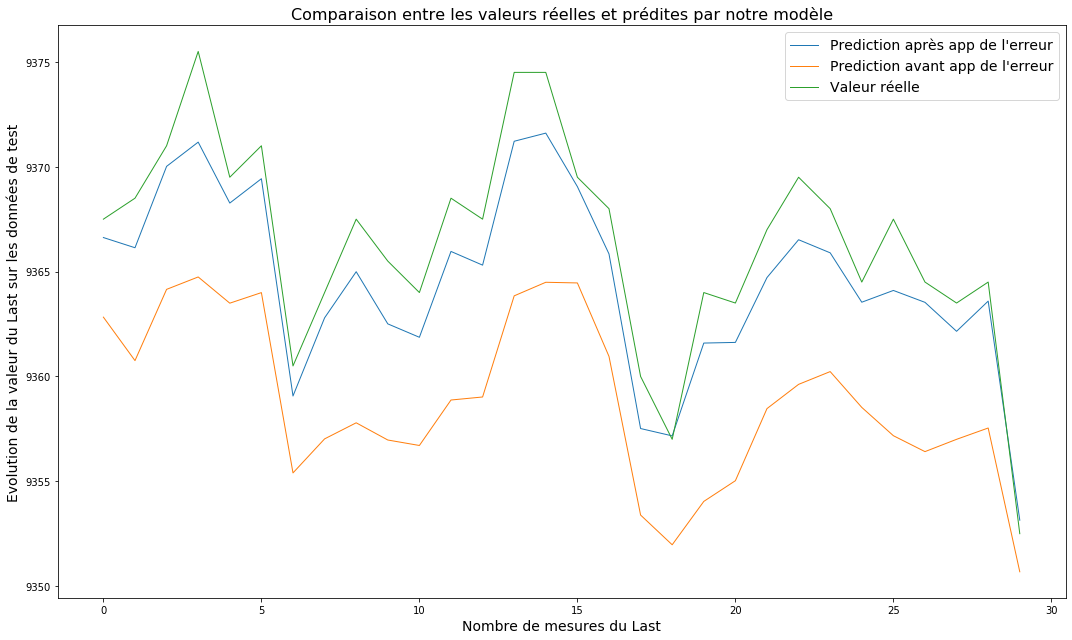

In [54]:
nb_points = 30
tracer_predictio_corr(last_prediction_corr_shift, last_prediction_reduit_shift, last_real_reduit_shift, nb_points)

In [49]:
rmse_corr = sqrt(mean_squared_error(last_prediction_corr_shift, last_real_reduit_shift))
rmse_corr

2.891272654214606

In [50]:
def erreur_classification(last_prediction_corr, df_corr):
    Y_hat=[]
    n_test = last_prediction_corr.shape[0]
    for i in range (1,n_test): 
        if last_prediction_corr[i] < last_prediction_corr[i-1]:
            Y_hat.append(-1)
        if last_prediction_corr[i] == last_prediction_corr[i-1]:
            Y_hat.append(0)
        if last_prediction_corr[i] > last_prediction_corr[i-1]:
            Y_hat.append(1)
            
    df_classification = df_corr.iloc[1:df_corr.shape[0]-1,:].copy(deep=True)
    df_classification.insert(df_classification.shape[1],'Y_hat',Y_hat)

    s = 0
    l = len(variables)
    n = df_classification.shape[0]
    for i in range (0,n):
        if df_classification.iloc[i, 4+l] != df_classification.iloc[i, 9+l]:
            s+=1
    erreur = (s/n)*100
    
    
    return erreur, df_classification

In [51]:
erreur_corr, df_classification = erreur_classification(last_prediction_corr_shift, df_corr)

In [52]:
erreur_corr

15.653040877367896

In [53]:
df_classification

,Open,High,Low,Volume_zscoring,priceChange_zscoring,Last,Y,Last_hat_norm,err,err_hat,Last_hat_corr,Y_hat
28257,1.321901,1.312766,1.316814,1.411702,-0.388716,1.322500,1,1.318448,0.004052,0.002711,1.321160,-1
28258,1.322615,1.317021,1.320708,0.325490,0.544018,1.324286,1,1.316967,0.007318,0.003845,1.320812,1
28259,1.324044,1.317021,1.318938,-0.632255,0.750429,1.327500,1,1.319394,0.008106,0.004190,1.323584,1
28260,1.327260,1.318440,1.321416,-0.386497,1.026158,1.323214,-1,1.319817,0.003397,0.004593,1.324410,-1
28261,1.322972,1.314894,1.321770,-0.560125,-0.783953,1.324286,1,1.318924,0.005362,0.003410,1.322334,1
...,...,...,...,...,...,...,...,...,...,...,...,...
30258,1.521972,1.515248,1.518938,3.247570,-1.868521,1.525000,1,1.508137,0.016863,0.011727,1.519865,-1
30259,1.524830,1.514539,1.521416,0.024667,0.739365,1.525357,1,1.505872,0.019486,0.013671,1.519543,1
30260,1.525188,1.518085,1.522478,-0.584860,0.044688,1.527500,1,1.507974,0.019526,0.012620,1.520594,1
30261,1.527688,1.517730,1.524248,-0.712437,0.602809,1.529286,1,1.510742,0.018544,0.012218,1.522960,1
